#ResNet


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

### Plain Networks

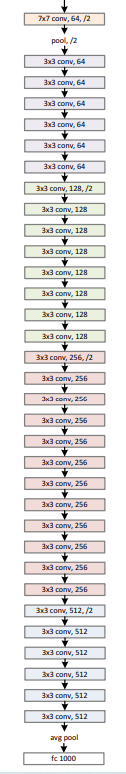

Convolution layer는 3x3 kernel을 사용

복잡도를 줄이기 위해 max-pooling, hidden, fc, dropout을 사용 안함

출력 feature-map 크기가 같은 경우, 해당 모든 layer는 모두 동일한 수의 filter로 설정

출력 feature-map 크기가 절반이 될 때에는, layer의 연산량 보존을 위해 filter의 개수를 2배로 늘린다.

출력 feature-map 크기를 줄일 때에는 pooling 대신에 convolution stride의 크기를 '2'로 설정

#### Conv block

In [2]:
def conv_batch(layer, channel, kernel_size, padding='same', strides=1, activation='relu', name='0'):
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.l2(1e-4),
                            padding=padding,
                            strides=strides,
                            name=f'conv_{name}')(layer)
    x = keras.layers.BatchNormalization(name=f'batch_{name}')(x)
    if activation:
        x = keras.layers.Activation(activation, name=f'act_{name}')(x)
    
    return x

#### Plain block

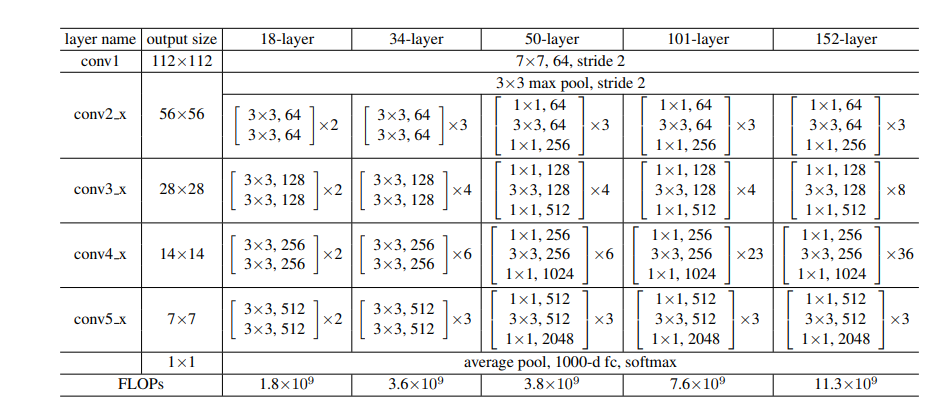

34와 50의 차이점을 잘보아야 한다.

우선 50은 1x1 -> 3x3 -> 1x1 순이다.

또한 filter의 크기가 64에서 256으로 4배 상승한다.

34는 3x3, 64로 고정이다.

In [3]:
def build_plain_block(input_layer, block_num=0, num_cnn=3, channel=64, is_50=True):
    x = input_layer
    
    # plain_50
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                x = conv_batch(x, channel, (1,1), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), name=f'{block_num}_{i}3')
            else:
                x = conv_batch(x, channel, (1,1), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), name=f'{block_num}_{i}3')
    # plain_34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                x = conv_batch(x, channel, (3,3), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
            else:
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')

    return x

#### Build plain network

In [4]:
 def build_plain(num_cnn_list, channel_list, is_50=True, cats_vs_dogs=False, input_shape=(32,32,3), num_classes=10, name='Plain_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape, name='Input')
    
    # first layer
    conv1 = conv_batch(input_layer, 64, (7,7), strides=2, name='first') # 첫 inputsize (7,7,64), stride 2
    plain = keras.layers.MaxPool2D(pool_size=(2,2), strides=2, name='maxpool_first')(conv1)# pooling 2
    
    # plain block
    for block_num, (cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        plain = build_plain_block(plain, block_num, cnn, channel, is_50)
    
    gap = keras.layers.GlobalAveragePooling2D(name='GAP')(plain)
    
    if cats_vs_dogs:
        output = keras.layers.Dense(1, activation='sigmoid',kernel_initializer='he_normal', name='FC')(gap)
    else:
        output = keras.layers.Dense(num_classes, activation='softmax',kernel_initializer='he_normal', name='FC')(gap)
    
    model = keras.Model(inputs=input_layer, outputs=output, name=name)
    
    return model

#### Plain-34

In [5]:
plain_34 = build_plain(num_cnn_list=[3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=False,
                       input_shape=(224,224,3),
                       name='Plain_34')
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 conv_first (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_first (BatchNormaliza  (None, 112, 112, 64)     256       
 tion)                                                           
                                                                 
 act_first (Activation)      (None, 112, 112, 64)      0         
                                                                 
 maxpool_first (MaxPooling2D  (None, 56, 56, 64)       0         
 )                                                               
                                                                 
 conv_0_01 (Conv2D)          (None, 56, 56, 64)        369

#### Plain-50

In [6]:
plain_50 = build_plain(num_cnn_list = [3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=True,
                       input_shape=(224,224,3))
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 conv_first (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_first (BatchNormaliza  (None, 112, 112, 64)     256       
 tion)                                                           
                                                                 
 act_first (Activation)      (None, 112, 112, 64)      0         
                                                                 
 maxpool_first (MaxPooling2D  (None, 56, 56, 64)       0         
 )                                                               
                                                                 
 conv_0_01 (Conv2D)          (None, 56, 56, 64)        416

### ResNet

기존의 neural net의 학습 목적은 input(x)을 타겟값(y)으로 mapping하는 함수 H(x)를 찾는 것이다.

따라서 H(X)-y를 최소화하는 방향으로 학습을 진행한다.

이때 이미지 classification과 같은 문제의 경우 x에 대한 타겟값 y는 사실 x를 대변하는 것으로 y와 x의 의미가 같게끔

mapping해야 한다. 즉, 강아지 사진의 pixel값이 input(x)로 주어질 때 이를 2개의 label 중 강아지가 1에 해당한다면 타겟값(y)를 1로 정해서 학습하는 것이 아닌 강아지 사진의 pixel값 (x)로 y를 mapping해야 한다.

따라서 네트워크의 출력값이 x가 되도록 H(x)-x를 최소화하는 방향으로 학습을 진행한다. 따라서 네트워크의 출력값이 x가 되도록 H(x)-x를 최소화하는 방향으로 학습을 진행한다.

F(x) = H(x) - x를 잔차라고 하며 이 잔차를 학습하는 것은 Residual learning이라 한다.

깊어지는 layer와 함께 떠오르는 의문은 '과연 더 많은 레이어를 쌓는 것만큼 network의 성능은 좋아질까' 입니다. 왜냐하면 이와 관련해서 악명높은 많은 문제들이 발생하는데 대표적으로 problem of vanishing/exploding gradients 문제 이다. 그래도 이 문제는 다양한 방법들로 개선되어왔다.

이 논문에서 깊게 다룰 문제는 Degradation Problem이다. network가 깊어질수록 accuracy가 떨어지는 (성능이 저하되는) 문제이다. 이 문제는 overfitting의 문제가 아니기 때문에 주목받는다. (오버피팅이면 깊이 layer의 train accuracy는 높고 test accuracy는 낮아야 하는데 이건 둘 다 낮다.)

이 degradation 문제는 모든 시스템이 optimize하기 쉬운 것이 아니라는 뜻이기 때문에 얕은 구조와 더 깊은 아키텍처를 비교해보려고 한다. (즉 이 논문에서 degradation의 문제는 더 깊은 레이어가 쌓을 수록 optimize가 복잡해지기 때문에 일어나는 부작용으로 보고 해결하려고 노력한다.)



먼저 간단하게 identity mapping layer를 추가해봤지만 실험을 통해 좋은 solution이 아니라는 결과를 얻었다. 그래서 이 논문에서는 skip connection을 이용한 Deep residual learning framework라는 개념을 도입한다.

Instead of hoping each few stacked layers directly fit a desired underlying mapping, we explicitly let these layers fit a residual mapping.: 쌓여진 레이어가 그 다음 레이어에 바로 적합되는 것이 아니라 잔차의 mapping에 적합하도록 만들었다.

기존의 바로 mapping 하는 것이 H(x)이면 이 논문에서는 비선형적인 layer 적합인 F(x) = H(x) - x를 제시한다. 이를 전개하면 H(x) = F(x) + x의 형태가 된다. 여기서는 residual mapping(잔차 매핑)이 기존의 mapping보다 optimize(최적화) 하기 쉽다는 것을 가정한다. (극단적으로 identity mapping이 최적이라고 할 때, 비선형 레이어를 쌓아서 identity mapping을 맞추는 것 보다 잔차를 0으로 만드는 것이 더 쉽다.) -> Function에 대해서 맞추는 것보다 0이라는 숫자 개념으로 잔차를 수렴하게 하는 것이 더 쉽기 때문에 쓰인다.

F(x) + x는 Shorcut Connection과 동일하게 이는 하나 또는 이상의 레이어를 skip하게 만들어준다. (이 모델의 아키텍처를 보면 건너뛴다는 것을 볼 수 있다.) 즉 여기서는 identity mapping으로 shortcut connection이 되게 하면서 skip을 만든다.

이 Identity Short Connection은 추가적인 파라미터도 필요하지 않고 복잡한 곱셈 연산도 필요하지 않는 것이 장점이다.

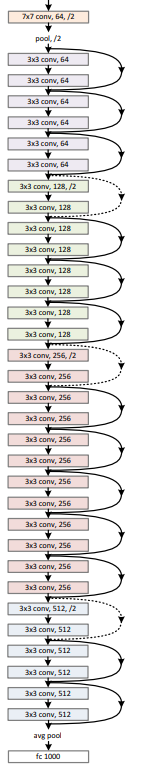

#### Residual block

인공신경망이 더 깊어질 수록 Gradient vanishing/exploding 문제가 커진다. 레이어간의 연결이 순서대로 연속적인 것만 있는 것이 아니라, 중간을 뛰어넘어 전달하는 shortcut이 추가된 것이다. 이렇게 되면 그래디언트를 잘 전달하여 gradient vanishing/exploding 문제를 해결하는 효과를 불러일으킬 수 있다.

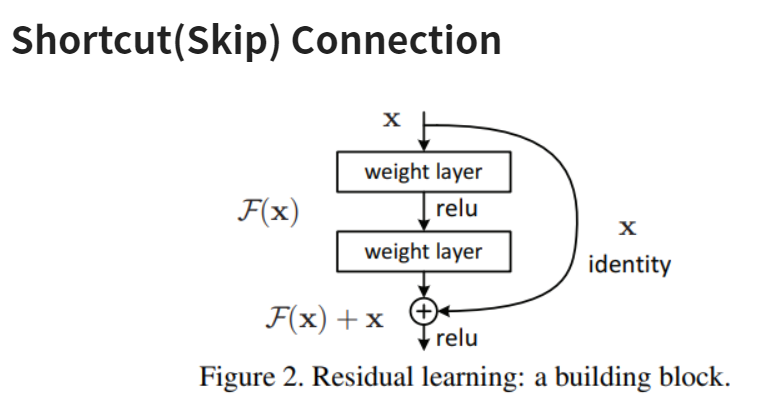

그림과 같이, shortcut connection 추가되어 있는 것을 확인할 수 있다.


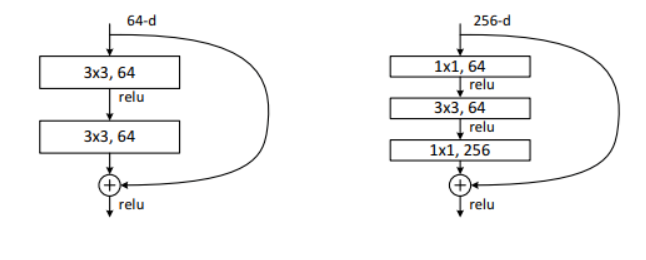

In [7]:
def build_residual_block(input_layer, block_num=0, num_cnn=3, channel=64, is_50=True):
    x = input_layer
    
    # ResNet 50
    if is_50:
        for i in range(num_cnn):
            if i==0:
                shortcut = conv_batch(x, channel*4, (1,1), strides=2, activation=None, name=f'_shortcut_{block_num}_{i}')
                x = conv_batch(x, channel, (1,1), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), activation=None, name=f'{block_num}_{i}3')
            else:
                shortcut = x
                x = conv_batch(x, channel, (1,1), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), activation=None, name=f'{block_num}_{i}3')
            
            x = keras.layers.Add(name=f'shortcut_add_{block_num}_{i}')([x, shortcut])
            x = keras.layers.Activation('relu', name=f'shortcut_act_{block_num}_{i}')(x)
    # ResNet 34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                shortcut = conv_batch(x, channel, (1,1), strides=2, activation=None, name=f'_shortcut_{block_num}_{i}')
                x = conv_batch(x, channel, (3,3), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), activation=None, name=f'{block_num}_{i}2')
            else:
                shortcut = x
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), activation=None, name=f'{block_num}_{i}2')
            
            x = keras.layers.Add(name=f'shortcut_add_{block_num}_{i}')([x, shortcut])
            x = keras.layers.Activation('relu', name=f'shortcut_act_{block_num}_{i}')(x)
    

    return x

#### Build ResNet

In [8]:
def build_resnet(num_cnn_list, channel_list, is_50=True, cats_vs_dogs=False, input_shape=(32,32,3), num_classes=10, name='ResNet_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape, name='Input')
    
    # first layer
    conv1 = conv_batch(input_layer, 64, (7,7), strides=2, name='first')
    res = keras.layers.MaxPool2D(pool_size=(2,2), strides=2, name='maxpool_first')(conv1)
    
    # Residual block
    for block_num, (cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        res = build_residual_block(res, block_num, cnn, channel, is_50)
        
    gap = keras.layers.GlobalAveragePooling2D(name='GAP')(res)
    if cats_vs_dogs:
        output = keras.layers.Dense(1, activation='sigmoid',kernel_initializer='he_normal', name='FC')(gap)
    else:
        output = keras.layers.Dense(num_classes, activation='softmax',kernel_initializer='he_normal', name='FC')(gap)
    
    model = keras.Model(inputs=input_layer, outputs=output, name=name)
    return model

#### ResNet-34

In [9]:
resnet_34 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=False,
                         input_shape=(224,224,3),
                         name='ResNet_34')
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_first (Conv2D)            (None, 112, 112, 64  9472        ['Input[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_first (BatchNormalizatio  (None, 112, 112, 64  256        ['conv_first[0][0]']             
 n)                             )                                                         

간단한 계산을 추가한 방법이라 parameter 수가 늘어나지 않은 것을 알 수 있다.

#### ResNet-50

In [10]:
resnet_50 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=True,
                         input_shape=(224,224,3),
                         name='ResNet_50')
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_first (Conv2D)            (None, 112, 112, 64  9472        ['Input[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_first (BatchNormalizatio  (None, 112, 112, 64  256        ['conv_first[0][0]']             
 n)                             )                                                         

### ResNet-34 vs ResNet-50 vs Plain-34 vs Plain-50

강아지와 고양이 사진을 가지고 어떤 모델이 가장 잘 분류하는 지 평가해보자.

#### 데이터셋 만들기

In [11]:
# Dataset(cats_and_dog)
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
)

In [12]:
# 데이터 정보 확인
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [13]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [14]:
# 데이터 전처리
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, (224,224)) # resize
    image = tf.cast(image, tf.float32) / 255.
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

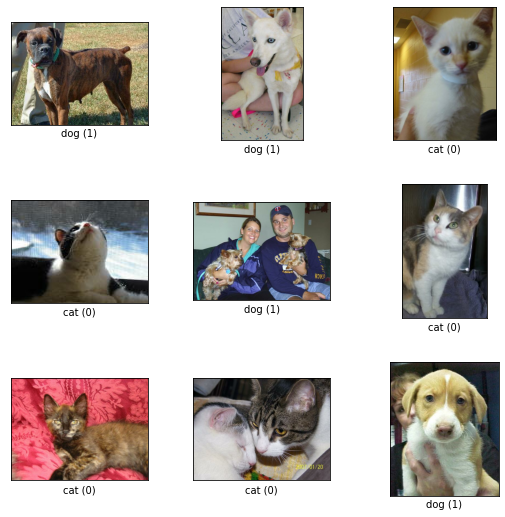

In [16]:
# train 데이터 확인
fig = tfds.show_examples(ds_train, ds_info)

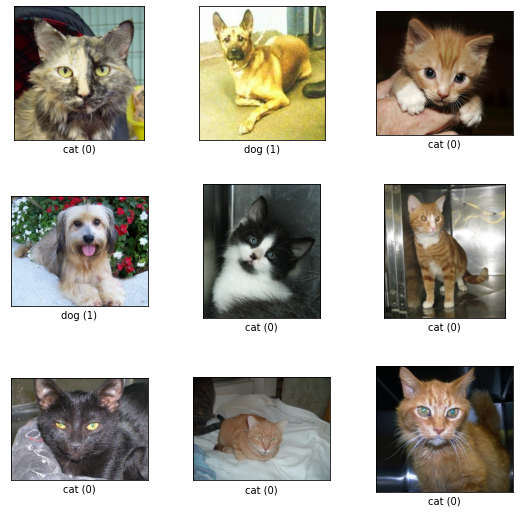

In [17]:
# test 데이터 확인
fig = tfds.show_examples(ds_test, ds_info)

### 훈련

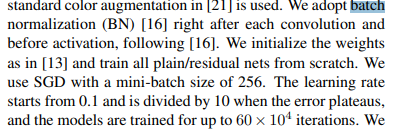

batch size 256

iteraction 60 x 10**4

논문은 위와 같지만, 편의상 

BATCH_SIZE = 32 
, iteration = 15000로 지정하겠다.

In [18]:
BATCH_SIZE = 32 #256
iteration = 15000 #600000
EPOCH = iteration*BATCH_SIZE//int(ds_info.splits['train'].num_examples)

In [19]:
EPOCH

20

In [20]:
# 훈련 데이터 준비
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [21]:
def scheduler(epoch, lr):
    if epoch == EPOCH//2:
        lr *=0.1
        print(lr)
    elif epoch == (EPOCH//4)*3:
        lr *=0.1
        print(lr)
    return lr

In [22]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.1, monitor='val_loss', patience=1, verbose=2, min_lr=1e-6)
# lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

In [23]:
resnet_34 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=False,
                         cats_vs_dogs=True,
                         input_shape=(224,224,3),
                         name='ResNet_34')

In [24]:
resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


654/654 [==============================] - 94s 118ms/step - loss: 2.2704 - accuracy: 0.5617 - val_loss: 2.0222 - val_accuracy: 0.5868 - lr: 0.1000
Epoch 2/20
654/654 [==============================] - ETA: 0s - loss: 1.8285 - accuracy: 0.6441
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
654/654 [==============================] - 74s 114ms/step - loss: 1.8285 - accuracy: 0.6441 - val_loss: 4.2336 - val_accuracy: 0.5113 - lr: 0.1000
Epoch 3/20
654/654 [==============================] - 74s 114ms/step - loss: 1.5969 - accuracy: 0.7044 - val_loss: 1.5775 - val_accuracy: 0.7062 - lr: 0.0100
Epoch 4/20
654/654 [==============================] - 74s 114ms/step - loss: 1.5332 - accuracy: 0.7348 - val_loss: 1.5151 - val_accuracy: 0.7382 - lr: 0.0100
Epoch 5/20
654/654 [==============================] - ETA: 0s - loss: 1.4823 - accuracy: 0.7519
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
654/654 [==============================] - 75s 

In [25]:
resnet_50 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=True,
                         cats_vs_dogs=True,
                         input_shape=(224,224,3))

In [26]:
resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/20
654/654 [==============================] - 78s 95ms/step - loss: 5.6269 - accuracy: 0.5500 - val_loss: 4.9238 - val_accuracy: 0.5004 - lr: 0.1000
Epoch 2/20
654/654 [==============================] - 61s 94ms/step - loss: 4.3462 - accuracy: 0.6347 - val_loss: 3.8975 - val_accuracy: 0.5924 - lr: 0.1000
Epoch 3/20
654/654 [==============================] - 61s 94ms/step - loss: 3.4463 - accuracy: 0.6900 - val_loss: 3.0964 - val_accuracy: 0.6862 - lr: 0.1000
Epoch 4/20
654/654 [==============================] - 62s 95ms/step - loss: 2.7507 - accuracy: 0.7351 - val_loss: 2.4907 - val_accuracy: 0.7235 - lr: 0.1000
Epoch 5/20
654/654 [==============================] - 62s 95ms/step - loss: 2.2287 - accuracy: 0.7605 - val_loss: 1.9991 - val_accuracy: 0.7821 - lr: 0.1000
Epoch 6/20
654/654 [==============================] - 62s 95ms/step - loss: 1.8148 - accuracy: 0.7812 - val_loss: 1.6619 - val_accuracy: 0.7765 - lr: 0.1000
Epoch 7/20
654/654 [==============================] - ETA:

In [27]:
plain_34 = build_plain(num_cnn_list=[3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=False,
                       cats_vs_dogs=True,
                       input_shape=(224,224,3),
                       name='Plain_34')

In [28]:
plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/20
654/654 [==============================] - 83s 109ms/step - loss: 2.0965 - accuracy: 0.5193 - val_loss: 1.9264 - val_accuracy: 0.4991 - lr: 0.1000
Epoch 2/20
654/654 [==============================] - 71s 109ms/step - loss: 1.7604 - accuracy: 0.5506 - val_loss: 1.6279 - val_accuracy: 0.5356 - lr: 0.1000
Epoch 3/20
654/654 [==============================] - 71s 109ms/step - loss: 1.5008 - accuracy: 0.5910 - val_loss: 1.5319 - val_accuracy: 0.5230 - lr: 0.1000
Epoch 4/20
654/654 [==============================] - 71s 109ms/step - loss: 1.3003 - accuracy: 0.6160 - val_loss: 1.4350 - val_accuracy: 0.5408 - lr: 0.1000
Epoch 5/20
654/654 [==============================] - 71s 109ms/step - loss: 1.1504 - accuracy: 0.6225 - val_loss: 1.1021 - val_accuracy: 0.6007 - lr: 0.1000
Epoch 6/20
654/654 [==============================] - ETA: 0s - loss: 1.0244 - accuracy: 0.6490
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
654/654 [==============================

In [29]:
plain_50 = build_plain(num_cnn_list = [3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=True,
                       cats_vs_dogs=True,
                       input_shape=(224,224,3))

In [30]:
plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/20
654/654 [==============================] - 119s 158ms/step - loss: 4.8284 - accuracy: 0.5050 - val_loss: 4.2712 - val_accuracy: 0.5223 - lr: 0.1000
Epoch 2/20
654/654 [==============================] - 103s 157ms/step - loss: 3.8478 - accuracy: 0.4991 - val_loss: 3.4483 - val_accuracy: 0.5169 - lr: 0.1000
Epoch 3/20
654/654 [==============================] - 103s 157ms/step - loss: 3.1112 - accuracy: 0.5482 - val_loss: 2.8073 - val_accuracy: 0.5516 - lr: 0.1000
Epoch 4/20
654/654 [==============================] - 103s 157ms/step - loss: 2.5445 - accuracy: 0.5948 - val_loss: 2.3817 - val_accuracy: 0.6173 - lr: 0.1000
Epoch 5/20
654/654 [==============================] - 103s 157ms/step - loss: 2.0919 - accuracy: 0.6420 - val_loss: 2.0360 - val_accuracy: 0.5342 - lr: 0.1000
Epoch 6/20
654/654 [==============================] - 103s 158ms/step - loss: 1.7284 - accuracy: 0.6832 - val_loss: 1.5967 - val_accuracy: 0.6662 - lr: 0.1000
Epoch 7/20
654/654 [==========================

### Comparison

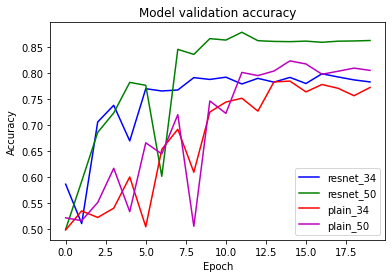

In [31]:
plt.plot(history_34.history['val_accuracy'], 'b')
plt.plot(history_50.history['val_accuracy'], 'g')
plt.plot(history_plain_34.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'plain_34', 'plain_50'], loc='lower right')
plt.show()

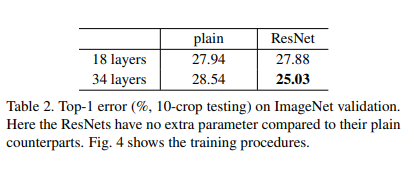

네트워크를 깊게 쌓은 50층이 34보다 정확성이 더 높게 나온다. 

위 그림의 논문 내용과 같게 34층을 쌓은 Resnet과 plain을 비교해보았을 때는 Resnet이 더 성능이 좋다.

ResNet50은 다른 모델들 보다 훨씬 더 높은 정확성을 보였다.

# 회고

논문 구현은 아직까지 많이 힘든 것 같다.

자만하지 말고 더욱 열심히 공부해야겠다.

### 출처 

https://jxnjxn.tistory.com/22

https://arxiv.org/pdf/1512.03385.pdf